<a href="https://colab.research.google.com/github/advcloud/colabtest/blob/main/yolov5wandb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q wandb
api_key = ""
!wandb login $api_key
projectn ='yolov5wandb3'
projectn1 =projectn+'/exp/weights/best.pt'
projectn2 ='/content/gdrive/My\ Drive/weights/'+projectn+'.pt'
DATASETk1 ="https://app.roboflow.com/ds/"

     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 54.7 MB/s 
     |████████████████████████████████| 145 kB 71.0 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Cloning into 'yolov5'...
remote: Enumerating objects: 12093, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 12093 (delta 23), reused 16 (delta 7), pack-reused 12047
Receiving objects: 100% (12093/12093), 11.92 MiB | 31.22 MiB/s, done.
Resolving deltas: 100% (8381/8381), done.
/content/yolov5
     |████████████████████████████████| 596 kB 4.8 MB/s 
Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [3]:
# Export code snippet and paste here
%cd /content
#!curl -L "https://public.roboflow.ai/ds/vJUg9kAnOG?key=YOUR DATASET HERE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L $DATASETk1 > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   2041      0 --:--:-- --:--:-- --:--:--  2041
100 16.3M  100 16.3M    0     0  22.3M      0 --:--:-- --:--:-- --:--:-- 22.3M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/im_109_jpg.rf.2b9b0eb402e2228cf85c1a9a7513c50b.jpg  
 extracting: test/images/im_118_jpg.rf.03eebc16e9f1ba724dd9fbf8eb7e0b57.jpg  
 extracting: test/images/im_158_jpg.rf.b1cb8e3d04bf1fb68fe5842abdbc1d5e.jpg  
 extracting: test/images/im_178_jpg.rf.a6a24737a301b28058235397ee410c02.jpg  
 extracting: test/images/im_230_jpg.rf.3476d7ab25e534eedb6054c934e1da7a.jpg  
 extracting: test/images/im_243_jpg.rf.d1bbbf63e09306c46aff7b5075f01376.jpg  
 extracting: test/images/im_327_jpg.rf.f1efc4a6c2b4f3678a882078

In [4]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['cone']

In [ ]:
%cd /content/yolov5

/content/yolov5


In [5]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
print(num_classes)

1


In [6]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [7]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [9]:
# train yolov5s
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 40 --epochs 40 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
#!python train.py --img 640 --batch 8  --data ../data.yaml --epochs 3  --project $projectn --weights yolov5s.pt --device 0 --cfg ./models/yolov5s.yaml

/content/yolov5
wandb: Currently logged in as: clair (claireye). Use `wandb login --relogin` to force relogin
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=40, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-234-gd490bdd Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr

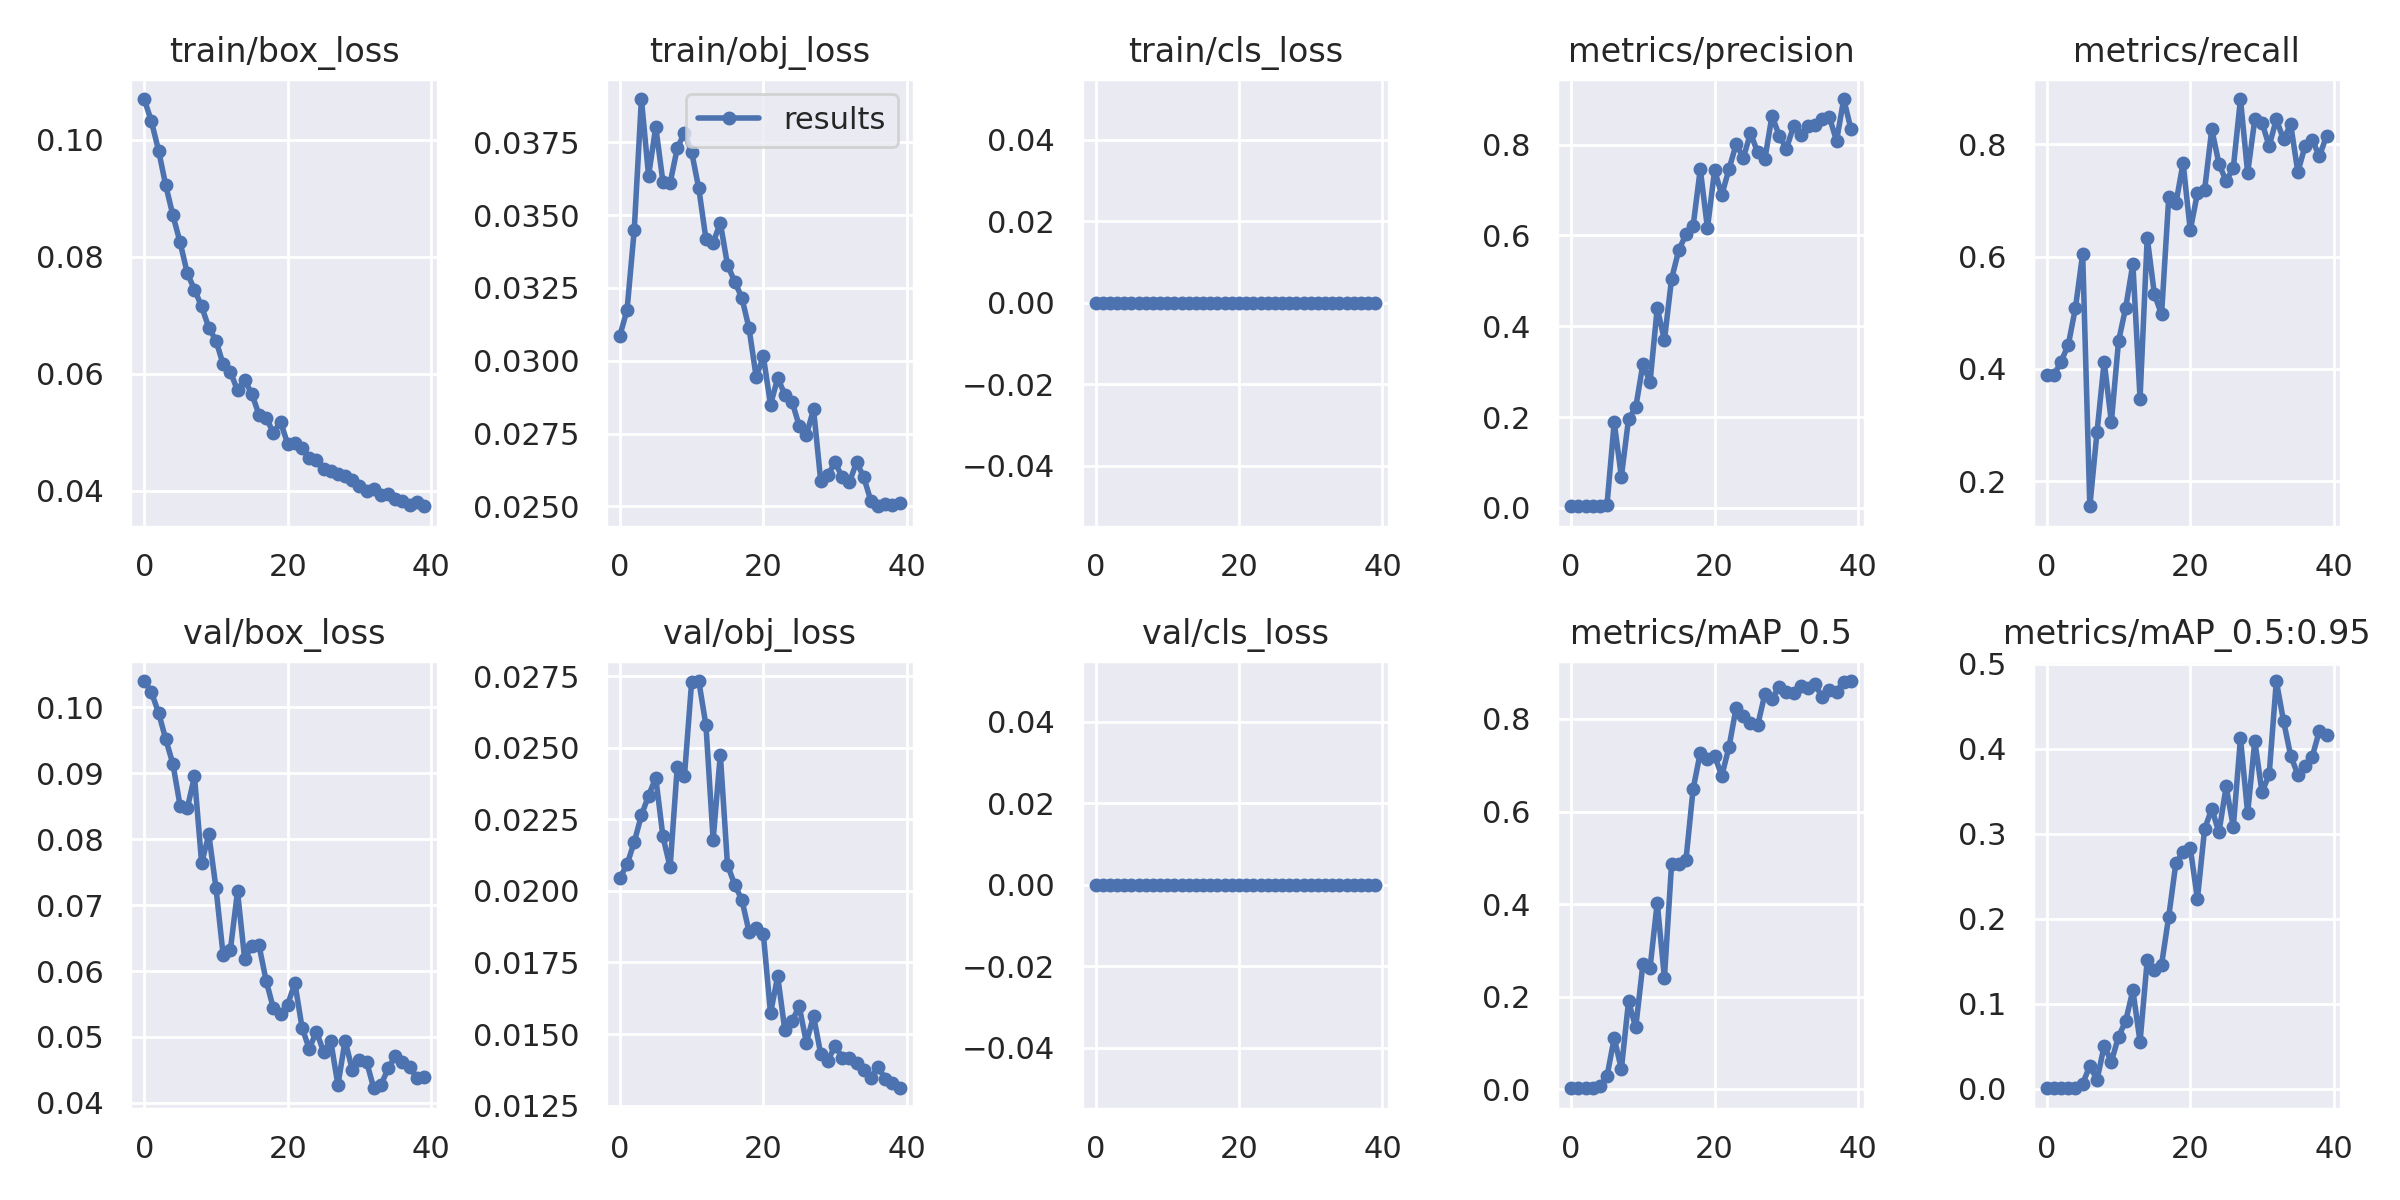

In [11]:

Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1500)  # view results.png

In [14]:
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --conf 0.5 --source ../test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-234-gd490bdd Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
image 1/30 /content/test/images/im_109_jpg.rf.2b9b0eb402e2228cf85c1a9a7513c50b.jpg: 640x640 4 cones, Done. (0.013s)
image 2/30 /content/test/images/im_118_jpg.rf.03eebc16e9f1ba724dd9fbf8eb7e0b57.jpg: 640x640 2 cones, Done. (0.014s)
image 3/30 /content/test/images/im_158_jpg.rf.b1cb8e3d04bf1fb68fe5842abdbc1d5e.jpg: 640x640 1 con

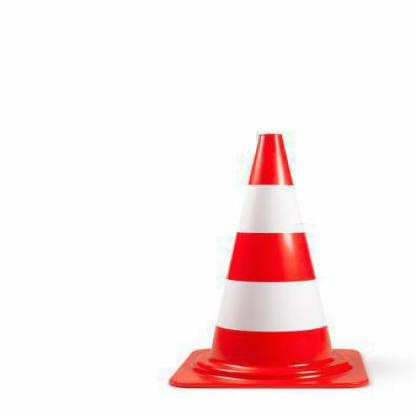

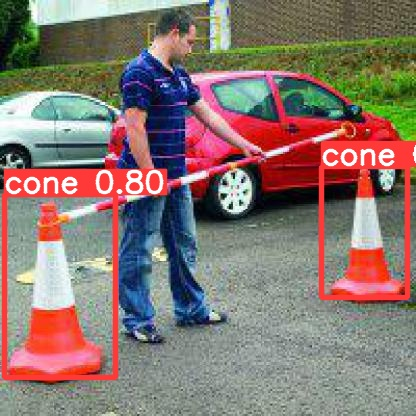

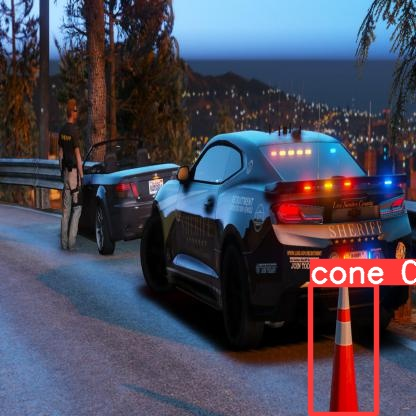

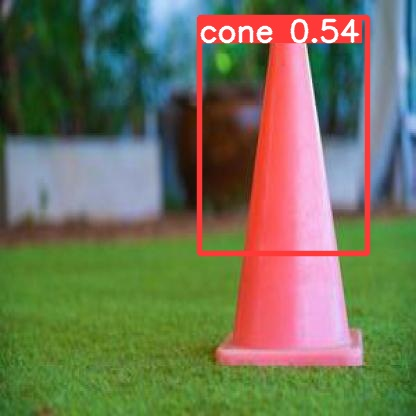

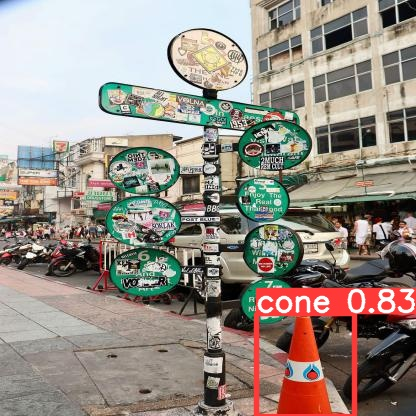

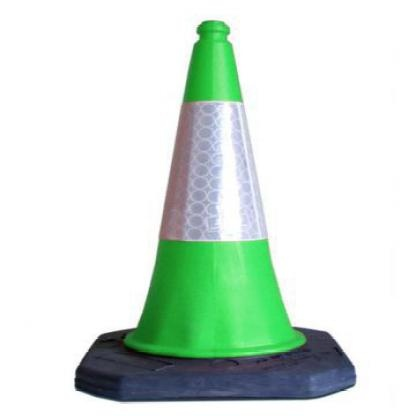

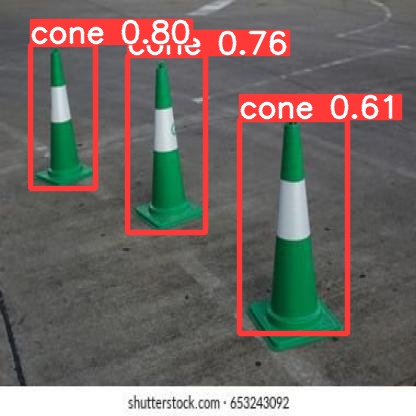

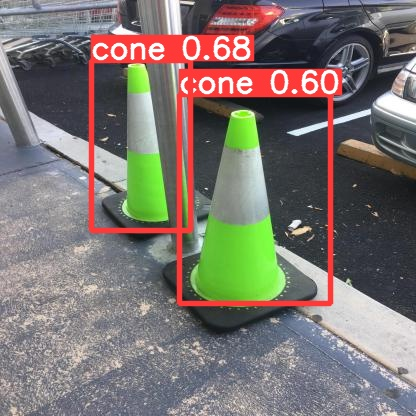

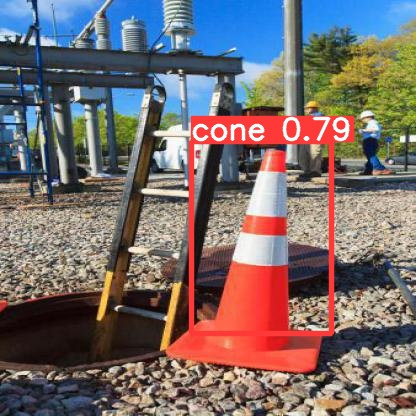

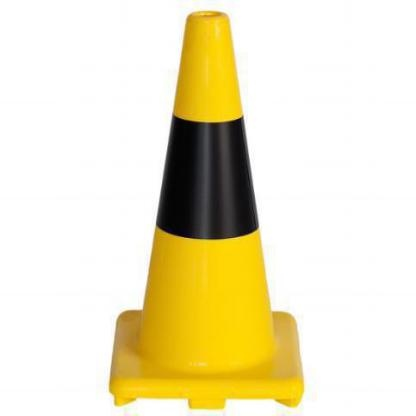

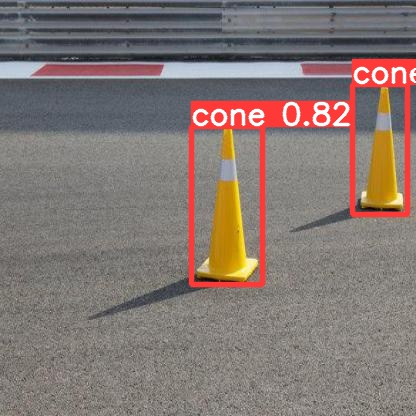

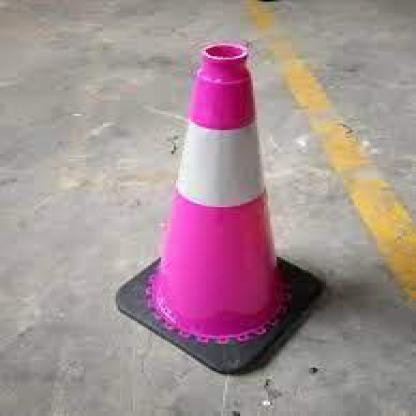

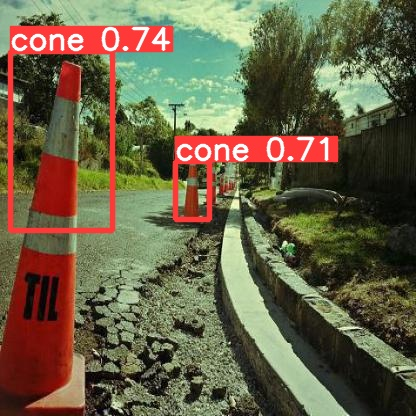

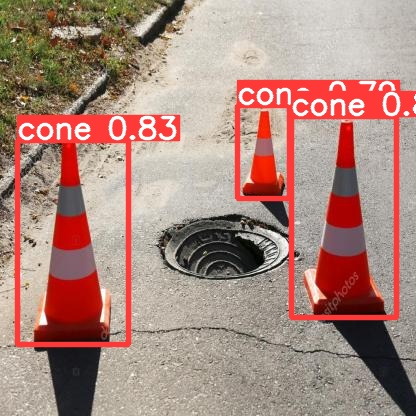

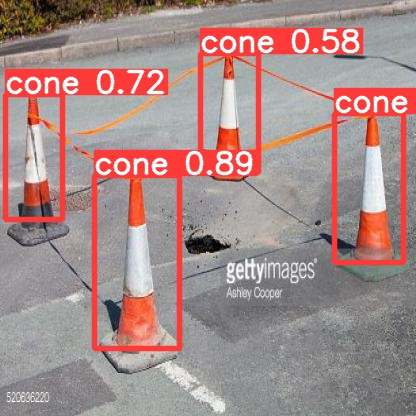

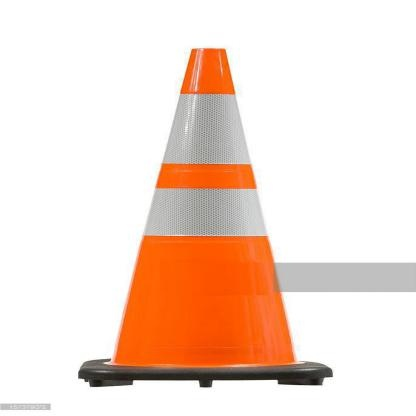

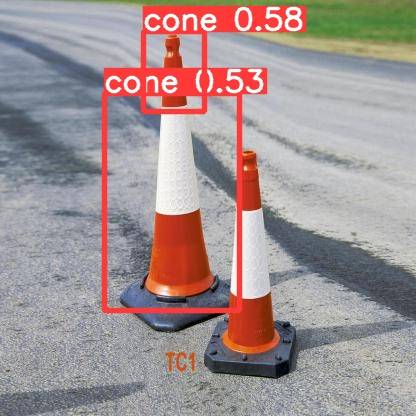

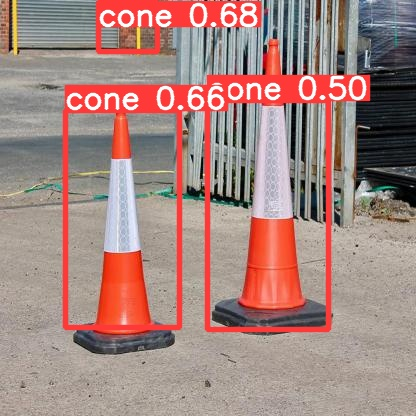

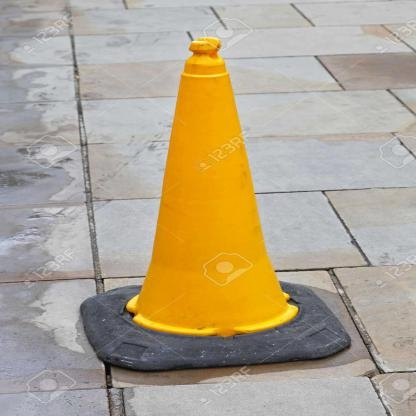

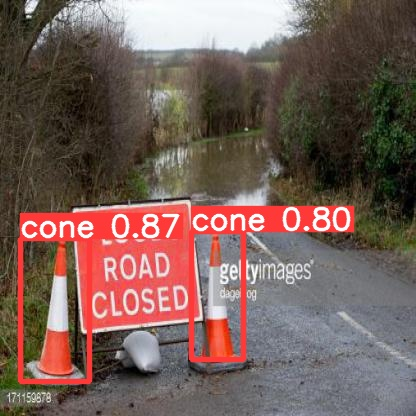

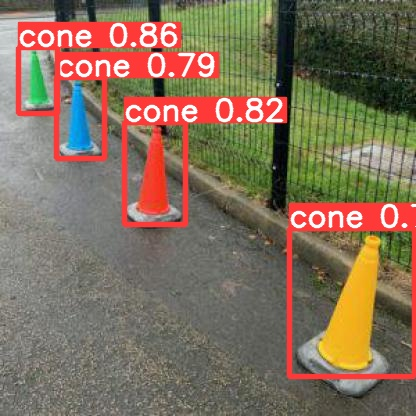

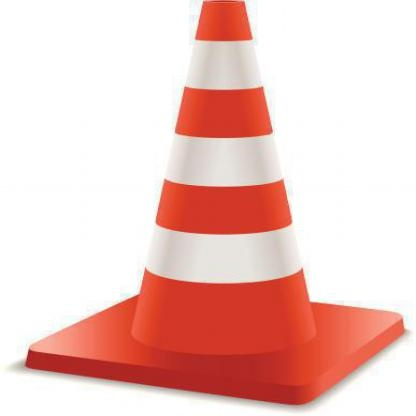

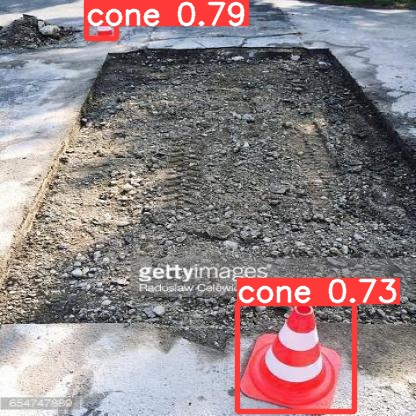

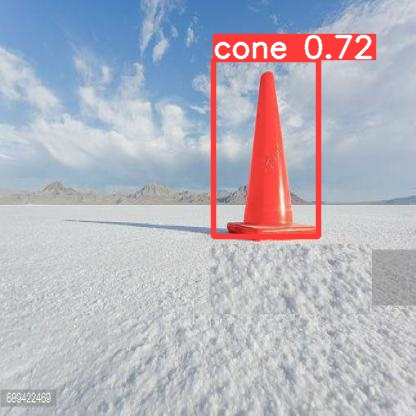

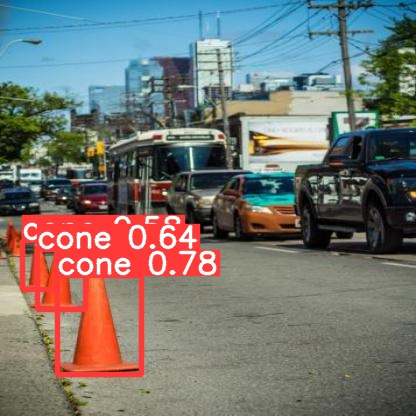

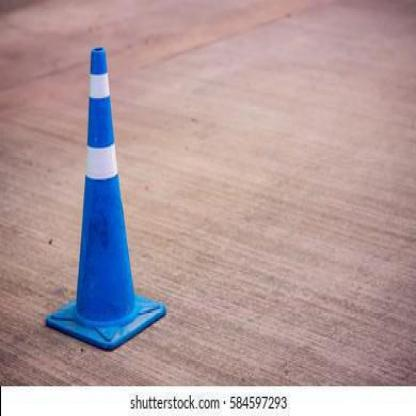

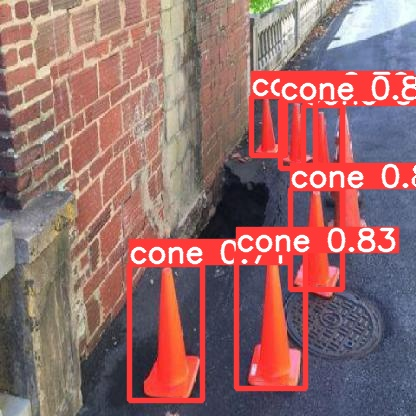

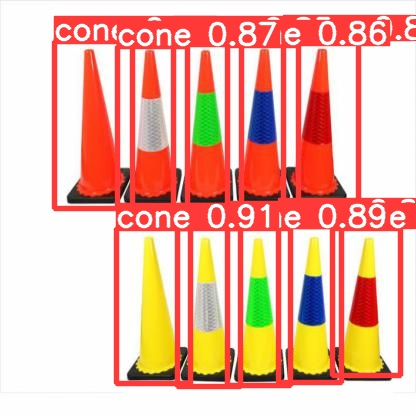

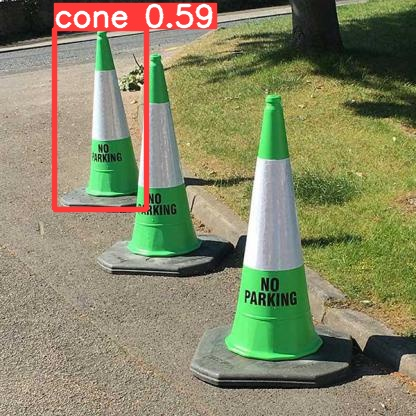

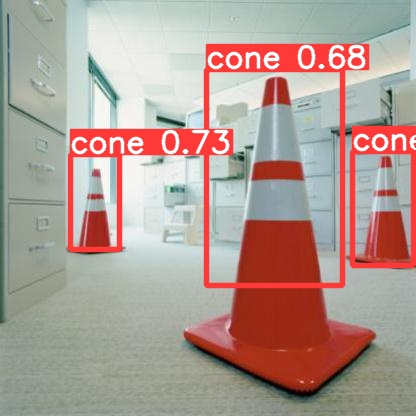

In [16]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
%ls /content/gdrive/My\ Drive/weights/

best_overall.pt  yolov5wandb1.pt


In [19]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive/weights/yolov5wandb2.pt